# Install Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles
# statistical models.
import os
import warnings # This is a library that handles warnings.
    
warnings.filterwarnings("ignore")
# Disable deprecation warnings that could indicate, for instance, a suspended library or
# feature. These are more relevant to developers and very seldom to analysts.
    
plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key

quandl.ApiConfig.api_key = 'CTQm1hF4BMHLYqzrQFsY'

In [3]:
# Importing the Federal Reserve Economic Data \"Real Retail and Food Services Sales\" variable.
data = quandl.get('FRED/RRSFS')

In [4]:
data.head()

,Value
Date,
1992-01-01,118651.0
1992-02-01,118480.0
1992-03-01,117700.0
1992-04-01,118156.0
1992-05-01,118548.0


In [5]:
data.shape

(361, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

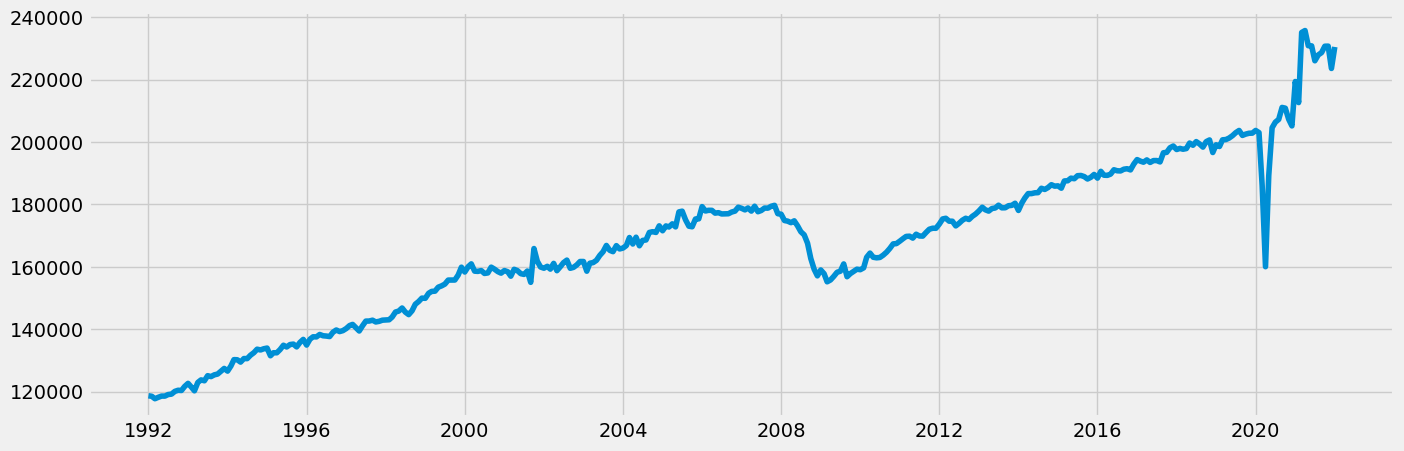

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the \"Date\" column as a filter
data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1992-01-01,118651.0
1,1992-02-01,118480.0
2,1992-03-01,117700.0
3,1992-04-01,118156.0
4,1992-05-01,118548.0


In [24]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2020-01-01')]

### I created a subset of values before COVID because the sharp decline in purchasing power during that time will throw off the forecast.

In [25]:
data_sub.shape

(240, 2)

In [26]:
data_sub.head()

,Date,Value
96,2000-01-01,158325.0
97,2000-02-01,160012.0
98,2000-03-01,160931.0
99,2000-04-01,158599.0
100,2000-05-01,158525.0


In [27]:
# Set the \"Date\" column as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from \"Date.\"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the \"Date\" column.

data_sub.head()

,Value
datetime,
2000-01-01,158325.0
2000-02-01,160012.0
2000-03-01,160931.0
2000-04-01,158599.0
2000-05-01,158525.0


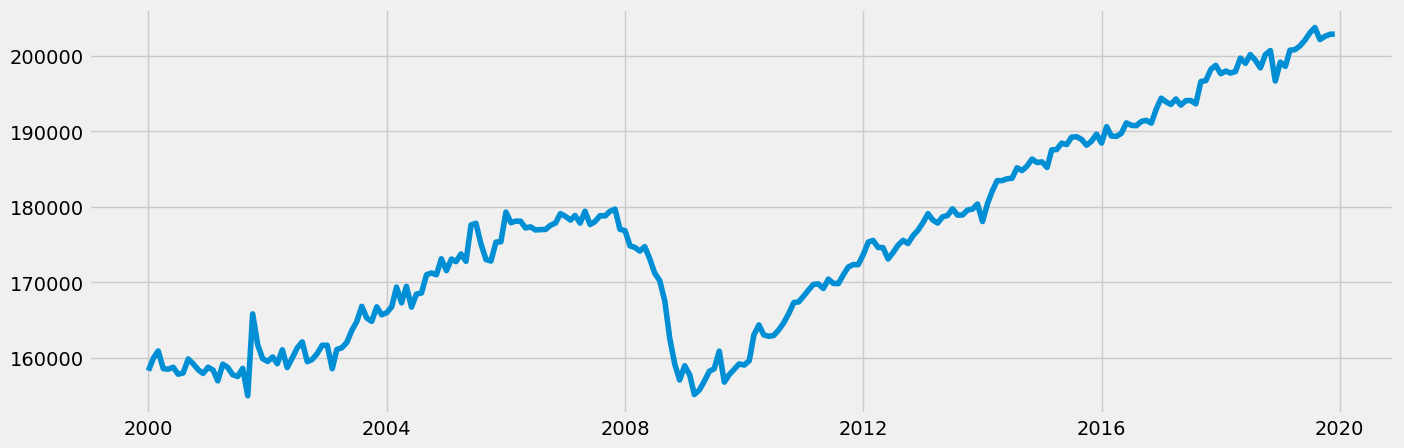

In [28]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [20]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [21]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

1

In [22]:
# Drop duplicate values
data_sub = data_sub.drop_duplicates()

In [23]:
# Confirm duplicate values were dropped
dups = data_sub.duplicated()
dups.sum()

0

# Time Series Analysis: Decomposition

In [29]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [30]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

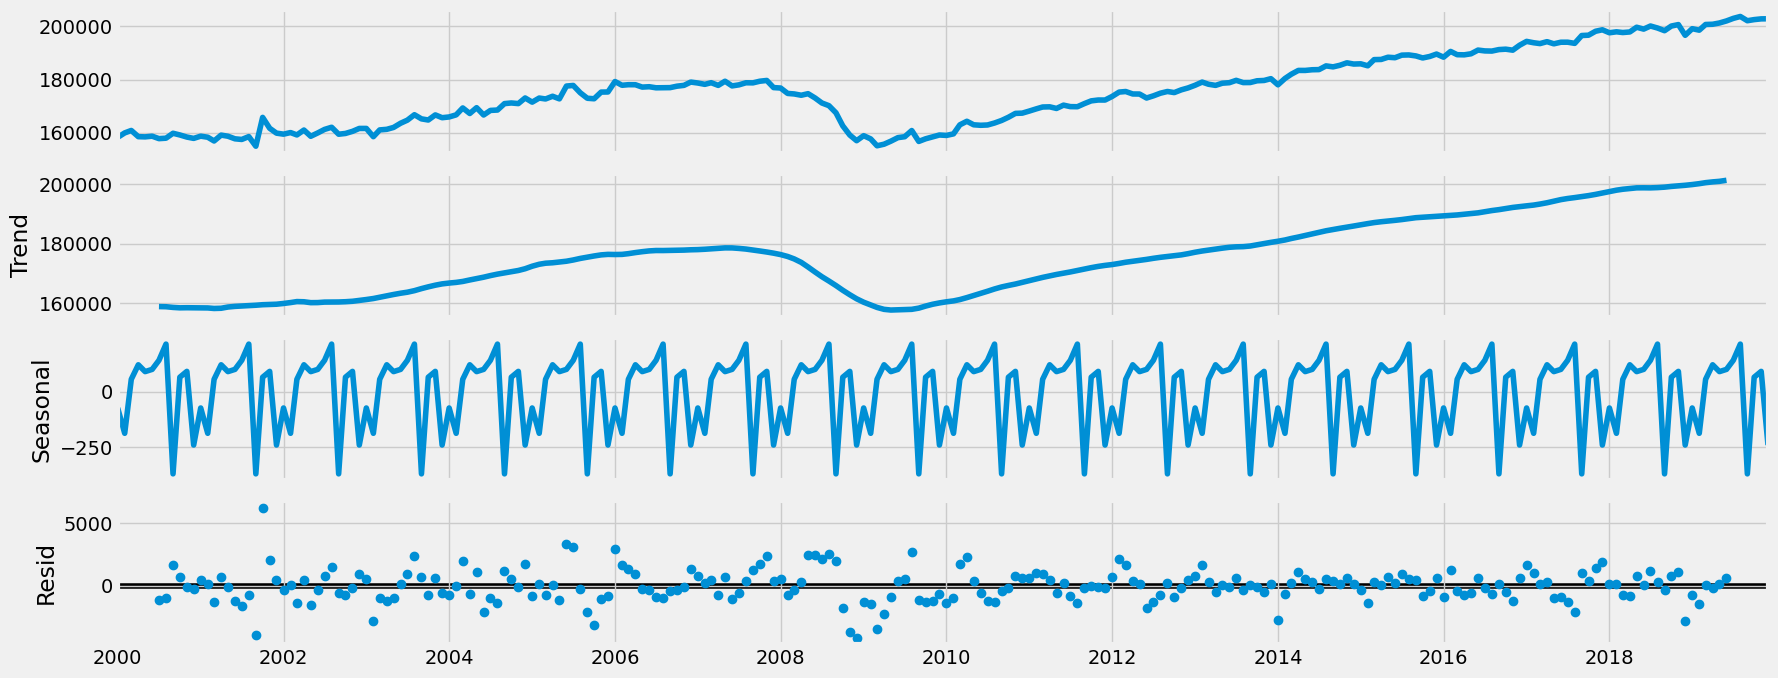

In [31]:
# Plot the separate components

decomposition.plot()
plt.show()

## Decomposition Analysis:
### Trend: There was an upward trend until 2007 during the global financial crisis. Retail and food sales declined through 2008 and have been steadily increasing as of of January 2020.
### Seasonality: The graph follows a continuous pattern of seasinality that includes a high peak and drop then fluctuations in between.
### Residuals: There is some noise on the graph but most points are close to the trend line.

# Testing for Stationarity

In [32]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.
    
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
        print (result)
   
# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.187302
p-value                          0.971540
Number of Lags Used              1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
dtype: float64
Test Statistic                   0.187302
p-value                          0.971540
Number of Lags Used              1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
dtype: float64
Test Statistic                   0.187302
p-value                          0.971540
Number of Lags Used              1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


### Since the test statistic (0.187302) is larger than the critical value and the p-value is greater than 0.05 we cannot reject the null hypothesis.

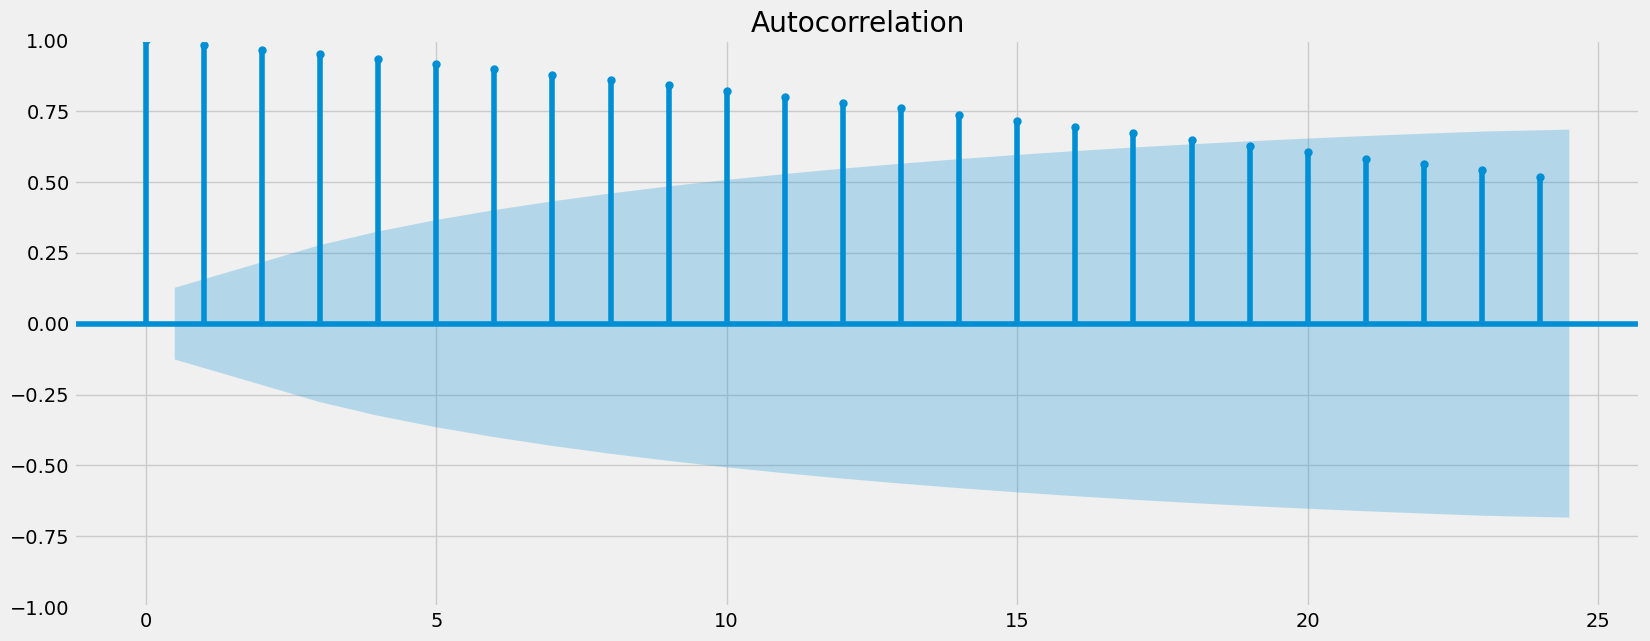

In [33]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### There are more than 10 lags above the confidence interval so this data needs to be stationarized.

# Stationarizing the Data

In [34]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [35]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing.
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [36]:
data_diff.head()

,Value
datetime,
2000-02-01,1687.0
2000-03-01,919.0
2000-04-01,-2332.0
2000-05-01,-74.0
2000-06-01,257.0


In [37]:
data_diff.columns

Index(['Value'], dtype='object')

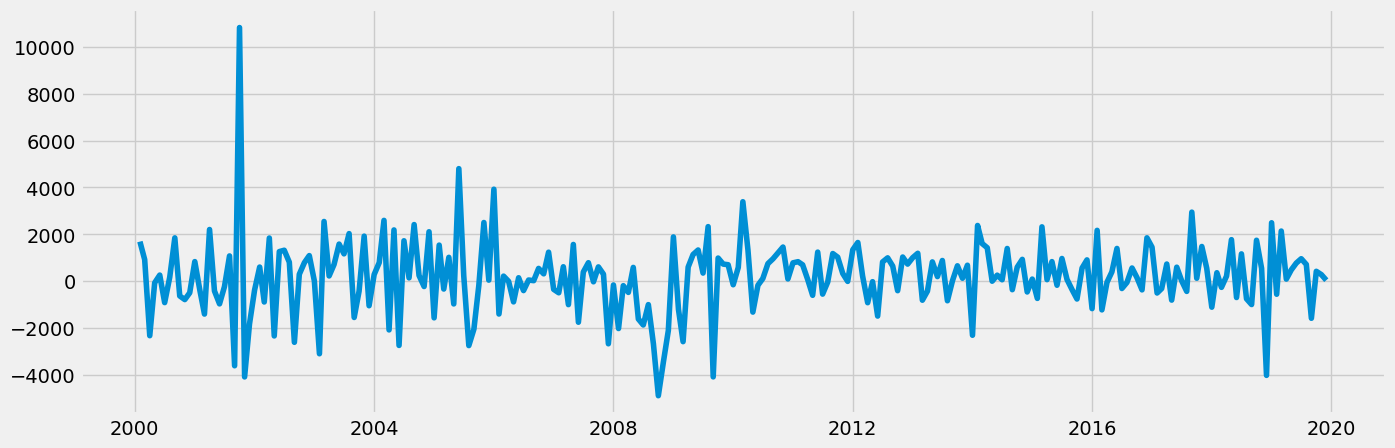

In [38]:
# Check out what the differencing did to the time-series curve
    
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [39]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -19.144504
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
dtype: float64
Test Statistic                 -19.144504
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
dtype: float64
Test Statistic                 -19.144504
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


### The test statistic (-19.144504) is smaller than the critical value (-3.458128) and the p-value is less than 0.05 so the null hypothesis can be rejected and the data is stationary.

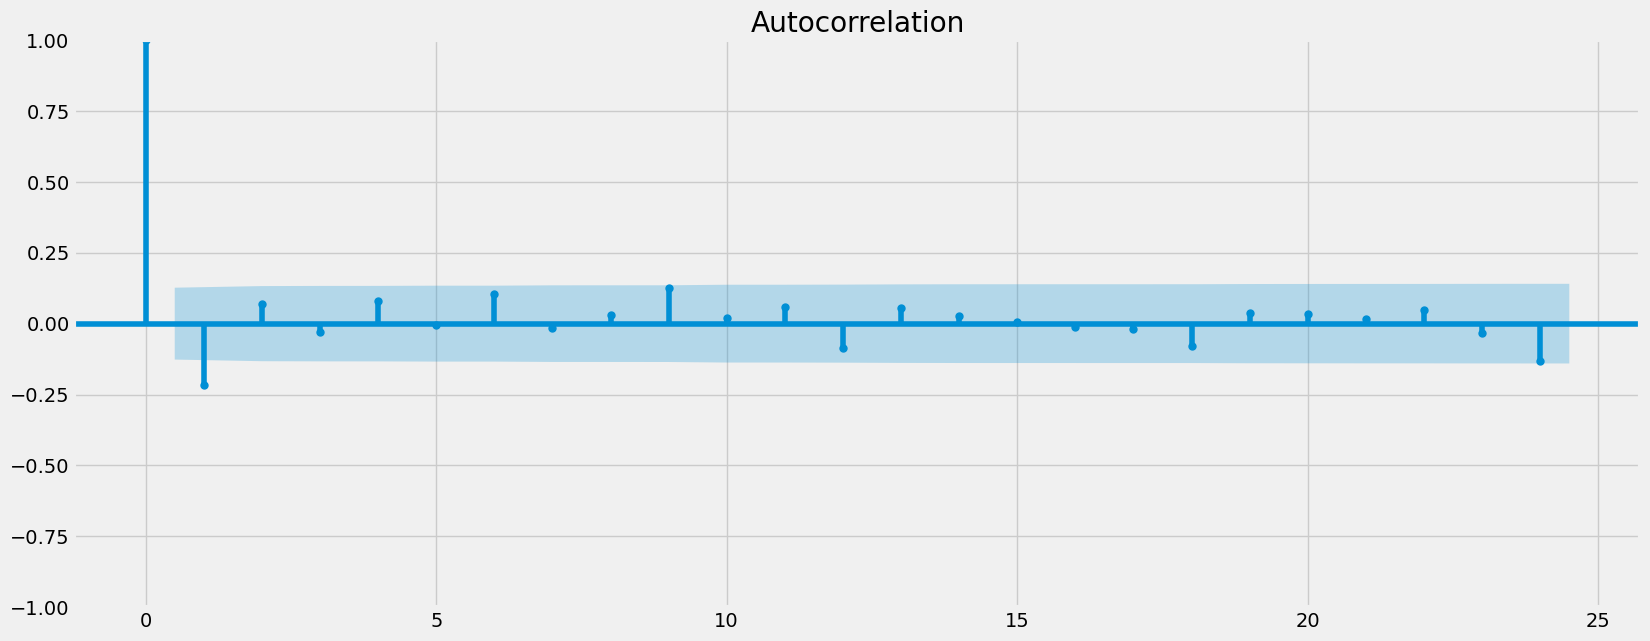

In [42]:
# Check the autocorrelation plot to confirm stationarity
plot_acf(data_diff)
plt.show()

### Confirmed!